In [30]:
import mainprogram
from PIL import Image
import numpy as np
import csv
import random
from skimage import io
from invert_LSB_module import *
import os
import pandas as pd

In [3]:
name = 'jet'
len_r = len_b = 4

In [4]:
stego_img = io.imread(f'processed_image/{name}.png')
authentication_code = hash_all_pixel(stego_img,len_r,len_b)

產生驗證碼完成


In [38]:
import mainprogram
from PIL import Image
import numpy as np
import csv
import random
from skimage import io
from invert_LSB_module import *
import os
import cv2

def authorize(name, len_r=4, len_b=4, alpha=2):
    # 初始化陣列
    U_second = []
    U_second_un = []
    detect_image = np.zeros((512, 512, 3))
    # 指定 CSV 檔案名稱
    csv_filename = f'list/{name}.csv'
    
    # 從 CSV 檔案讀取資料
    with open(csv_filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        # 跳過表頭
        next(reader)
        # 將資料放入陣列
        for row in reader:
            if row[0].strip() != "":
                U_second.append(int(row[0]))
            if row[1].strip() != "":
                U_second_un.append(int(row[1]))
                
    print("U_second:", U_second)
    print("U_second_un:", U_second_un)
 
    stego_img = io.imread(f'embeding_noise/{name}.png')
    I = Image.open(f'processed_image/{name}.png').convert('RGB')
    I = np.array(I)
    gray_img = rgb2gray(stego_img)
    bin_matrix = dec2bin(stego_img)

    len_bb = (len_r + len_b) // 2

    # 開始驗證
    detected_error = 0
    divid4 = (stego_img//(2**len_r))*(2**len_r)
    
    for i in range(stego_img.shape[0]):
        for j in range(stego_img.shape[1]):
            ii = i * stego_img.shape[1] + j + 1
            detect_image[i][j] = (255, 255, 255)
            flag = True
            if gray_img[i][j] in U_second_un:
                ac1 = bin_matrix[i][j][2][6:] #取出的驗證碼
                ac2 = dec2bin(gggg(stego_img[i][j], ii, alpha))[2][6:] #算出的驗證碼
                if ac1 == ac2:
                    detect_image[i][j] = (0, 0, 0) 
                    flag = False   
            elif gray_img[i][j] in U_second:
                ac1 = bin_matrix[i][j][2][8-len_bb:] 
                ac2 = dec2bin(proposed_unsolvable_case(stego_img[i][j], ii, len_bb))[2][8-len_bb:]
                if ac1 == ac2:
                    detect_image[i][j] = (0, 0, 0) 
                    flag = False
            else:
                a = int(Embedding(bin_matrix[i][j][2],authentication_code[i][j][:len_r],length=len_r),2)#red
                b = int(Embedding(bin_matrix[i][j][2],authentication_code[i][j][:len_r],1,length=len_r),2)#red
                ac_b = eee(a,b,stego_img[i][j][2])
                c = int(Embedding(bin_matrix[i][j][0],authentication_code[i][j][len_r:],length=len_b),2)#blue
                d = int(Embedding(bin_matrix[i][j][0],authentication_code[i][j][len_r:],1,length=len_b),2)#blue
                ac_r = eee(c,d,stego_img[i][j][0])

                current_r = int(bin_matrix[i][j][0],2)
                current_b = int(bin_matrix[i][j][2],2)
                if ac_r == current_r and ac_b == current_b:
                    detect_image[i][j] = (0, 0, 0)
                    flag = False
            if flag:
                detected_error += 1

    diff_pixels = 0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if(I[i,j] != stego_img[i,j]).any():
               diff_pixels+=1 
               
    accuracy = detected_error/diff_pixels
    print(f"Detected error: {detected_error}, Actual error: {diff_pixels}, Accuracy: {accuracy}")
    io.imshow(detect_image.astype(np.uint8))
    return detected_error
    
def embeding(image,n):
    def noise(I,Noise):
        n_r,n_c = Noise.shape[0],Noise.shape[1]

        r_base = random.randint(0,I.shape[0]-n_r)
        c_base = random.randint(0,I.shape[1]-n_c)
        for i in range(n_r):
            for j in range(n_c):
                if(Noise[i, j,3]==0):
                    continue
                for k in range(3):
                    I[i+r_base,j+c_base,k] = Noise[i,j,k]

        return I
    I=image.copy()
    path2 = "noise/"+n+".png"
    I2=io.imread(path2)
    e = noise(I,I2)
    io.imshow(e)
    #io.show() 
    return e

def PSNR(name):
    # 讀取圖片
    img1 = cv2.imread(f'processed_image/{name}.png')
    img2 = cv2.imread(f'image/{name}.tiff')

    # 計算 MSE
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        print("兩張圖片完全相同")
    else:
        # 計算 PSNR
        PIXEL_MAX = 255.0
        psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
        print(f"PSNR: {psnr} dB")
    return psnr

In [57]:
from matplotlib import pyplot as plt
import mainprogram
from importlib import reload
reload(mainprogram)

imagelist = ['bean']

l = [2, 3, 4]
results = []
name = 'jet'
for lr in l:
    for name in imagelist:
        image = np.array(Image.open(f'image/{name}.tiff').convert('RGB'),np.uint8)
        Stego, payload = mainprogram.propose_main(name,image, lr, lr, 2)
        psnr = PSNR(name)
        results.append({
            "name": name,
            "lr": lr,
            "psnr": psnr,
            "payload": payload
        })

df = pd.DataFrame(results, columns=["name", "lr", "psnr", "payload"])
df.to_csv(f"processed_data/{name}.csv", index=False, encoding="utf-8-sig")
# error_image = embeding(Stego, 'jet')
# io.imsave(f'embeding_noise/{name}.png', error_image.astype(np.uint8))
#authorize(name)

產生驗證碼完成


c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:272: RuntimeWarning: overflow encountered in scalar subtract
  error2 = abs(b-x)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:271: RuntimeWarning: overflow encountered in scalar subtract
  error1 = abs(a-x)


U長= 2


c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:162: RuntimeWarning: overflow encountered in scalar subtract
  distance = math.sqrt((group[0] - pixel[0])**2 + (group[1] - pixel[1])**2 + (group[2] - pixel[2])**2)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:162: RuntimeWarning: overflow encountered in scalar add
  distance = math.sqrt((group[0] - pixel[0])**2 + (group[1] - pixel[1])**2 + (group[2] - pixel[2])**2)


PSNR: 47.65753829247523 dB
產生驗證碼完成


c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:271: RuntimeWarning: overflow encountered in scalar subtract
  error1 = abs(a-x)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:272: RuntimeWarning: overflow encountered in scalar subtract
  error2 = abs(b-x)


U長= 2


c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:162: RuntimeWarning: overflow encountered in scalar subtract
  distance = math.sqrt((group[0] - pixel[0])**2 + (group[1] - pixel[1])**2 + (group[2] - pixel[2])**2)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:162: RuntimeWarning: overflow encountered in scalar add
  distance = math.sqrt((group[0] - pixel[0])**2 + (group[1] - pixel[1])**2 + (group[2] - pixel[2])**2)


OverflowError: Python integer -2 out of bounds for uint8

C:\Users\nchulib\AppData\Local\Temp\ipykernel_2424\680576182.py:108: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(e)


U_second: [25, 26, 27, 28, 30, 31, 32, 43, 44, 45, 46, 47, 48, 50, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
U_second_un: []


c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:162: RuntimeWarning: overflow encountered in scalar subtract
  distance = math.sqrt((group[0] - pixel[0])**2 + (group[1] - pixel[1])**2 + (group[2] - pixel[2])**2)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:162: RuntimeWarning: overflow encountered in scalar add
  distance = math.sqrt((group[0] - pixel[0])**2 + (group[1] - pixel[1])**2 + (group[2] - pixel[2])**2)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:272: RuntimeWarning: overflow encountered in scalar subtract
  error2 = abs(b-x)
c:\Users\nchulib\Desktop\vscode\code\invert_LSB_module.py:271: RuntimeWarning: overflow encountered in scalar subtract
  error1 = abs(a-x)


Detected error: 5628, Actual error: 6069, Accuracy: 0.9273356401384083


C:\Users\nchulib\AppData\Local\Temp\ipykernel_2424\680576182.py:87: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(detect_image.astype(np.uint8))


5628

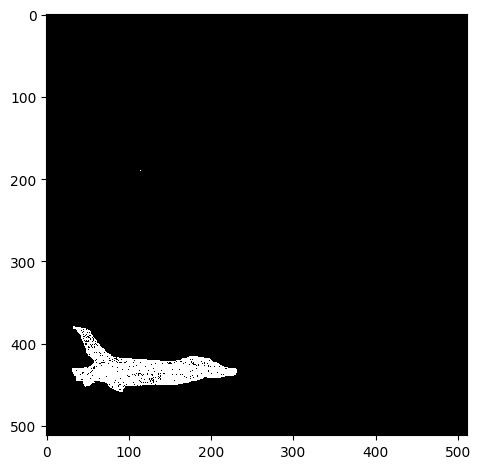

In [24]:
error_image = embeding(Stego, 'jet')
io.imsave(f'embeding_noise/{name}.png', error_image.astype(np.uint8))
authorize('jet')